# Visualizing a series of observed and surrogate networks

In [18]:
from pathlib import Path
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import networkx as nx

from sbm.sampling import sample_sbm_graph_from_fit
from sbm.io import SBMFit, SBMWriter, GraphLoader
from sbm.noisy_fit import create_sbm_noise

RNG = np.random.default_rng(0)

In [19]:
name = "lastfm_asia"
sbm = SBMWriter.load(
    Path(f"/Users/lmmi/anon_sbm/results/sbm_fits/sbm_fit_{name}_cooling_rate_0_9999_force_undirected_True_init_method_metis_min_block_size_3")
)
g = GraphLoader.load(
    Path(f'/Users/lmmi/anon_sbm/data/processed/{name}.edgelist'),
    force_undirected=True, # type: ignore
    )

Loading SBM fit from /Users/lmmi/anon_sbm/results/sbm_fits/sbm_fit_lastfm_asia_cooling_rate_0_9999_force_undirected_True_init_method_metis_min_block_size_3


In [20]:
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.sparse import isspmatrix_csr


def plot_csr_network_igraph(
    ax,
    csr_adj,
    title="",
    *,
    layout="kamada_kawai",      # "fr" (Fruchterman-Reingold) or any igraph layout name
    base_node_size=5,          # pixel diameter of the least-connected node
    max_node_size=10,
    node_cmap=cm.magma,
    with_labels=False,
    restrict_to_lcc=True,
):
    """
    Draw an undirected graph stored as a CSR array on the supplied Matplotlib Axes.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Host axes created by plt.subplots.
    csr_adj : scipy.sparse.csr_array / csr_matrix
        Symmetric adjacency matrix.  Non-zeros are treated as edge weights.
    title : str
        Subplot title.
    layout : str | (n,2) array
        igraph layout name or explicit coordinates.
    *size / *width : float
        Ranges for vertex bubble diameters and edge strokes (pixels).
    node_cmap : matplotlib colormap
        Vertex colour map keyed on degree.
    with_labels : bool
        Draw integer node labels.
    """

    # 1 ────────── build igraph graph from sparse input

    n = csr_adj.shape[0]
    coo = csr_adj.tocoo()
    mask = coo.row < coo.col                      # keep each undirected edge once
    edges = list(zip(coo.row[mask], coo.col[mask]))
    weights = coo.data[mask].astype(float).tolist()

    g = ig.Graph(n=n, edges=edges, directed=False)
    if restrict_to_lcc:
        g = g.connected_components().giant()

    if weights:
        g.es["weight"] = weights  # optional

    # 2 ────────── vertex/edge aesthetics
    deg = np.array(g.degree())
    deg_norm = (deg - deg.min()) / (deg.ptp() + 1e-9)
    g.vs["size"] = (base_node_size + deg_norm * (max_node_size - base_node_size)).tolist()

    rgba = node_cmap(deg_norm)
    g.vs["color"] = [cm.colors.to_hex(c) for c in rgba]
    g.vs["frame_color"] = ["white"] * n
    g.vs["frame_width"] = 0.1

    if "weight" in g.es.attributes():
        w = np.array(weights)
        w_norm = (w - w.min()) / (w.ptp() + 1e-9)
    else:
        w_norm = np.zeros(len(g.es))
    g.es["width"] = 0.1 #(base_edge_width + w_norm * (max_edge_width - base_edge_width)).tolist()
    g.es["color"] = ["#bbbbbb"] * len(g.es)

    # 3 ────────── layout
    if isinstance(layout, str):
        try:
            coord = g.layout(layout)
            coord = np.array(coord)
        except ValueError:
            # if the layout name is not recognized, use a default layout
            raise ValueError(f"Unknown layout: {layout}. Please use a valid igraph layout name.")
    else:                       # numpy array supplied
        coord = np.array(layout)

    # scale limits to fit the graph
    x_min, x_max = min(coord[:, 0]), max(coord[:, 0])
    y_min, y_max = min(coord[:, 1]), max(coord[:, 1])

    # set data to range between 0 and 1 
    coord[:, 0] = (coord[:, 0] - x_min) / (x_max - x_min)
    coord[:, 1] = (coord[:, 1] - y_min) / (y_max - y_min)
    
    # 4 ────────── draw
    ax.set_title(title, fontsize=12)
    ax.axis("off")
    ig.plot(
        g,
        target=ax,
        layout=coord,
        vertex_size=g.vs["size"],
        vertex_color=g.vs["color"],
        vertex_frame_width=g.vs["frame_width"],
        vertex_frame_color=g.vs["frame_color"],
        edge_width=g.es["width"],
        edge_color=g.es["color"],
        vertex_label=g.vs.indices if with_labels else None,
        vertex_label_size=8,
    )

    scale = 1.025
    ax.set_xlim(1-scale, scale)
    ax.set_ylim(1-scale, scale)


In [21]:
EPS, DELTA, ALPHA = 1, 1e-4, 1-1e-4

sbm_g = sample_sbm_graph_from_fit(sbm, RNG)

noise = create_sbm_noise(sbm, EPS, DELTA, ALPHA, noise_type="heterogeneous_gaussian")

lasso_noisy_fit = noise.sample_sbm_fit(RNG, post='lasso')
lasso_g = sample_sbm_graph_from_fit(lasso_noisy_fit, RNG)

naive_noisy_fit = noise.sample_sbm_fit(RNG, post='naive')
naive_g = sample_sbm_graph_from_fit(naive_noisy_fit, RNG)

max σ_n: 0.042, max σ_e: 0.163
[LASSO]    Added 0 edges to previously-zero pairs
[NAIVE]    Added 0 edges to zero pairs.


In [22]:
# check that graph is undirected
assert (sbm_g.adjacency != sbm_g.adjacency.T).sum() == 0,\
    "The sampled SBM graph is not undirected."
assert (lasso_g.adjacency != lasso_g.adjacency.T).sum() == 0,\
    "The lasso noisy graph is not undirected."
assert (naive_g.adjacency != naive_g.adjacency.T).sum() == 0,\
    "The naive noisy graph is not undirected."

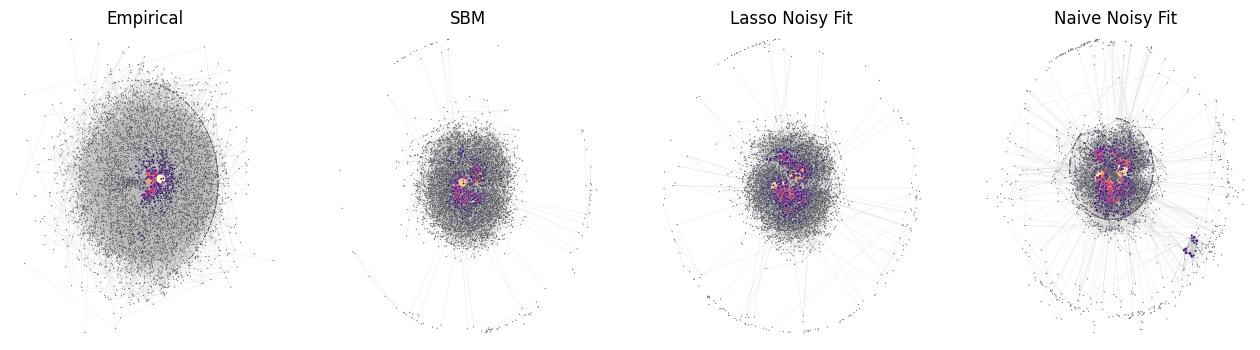

In [23]:
fig, ax = plt.subplots(ncols=4, figsize=(16, 4))

for idx, (name, adjacency) in enumerate(
    [
        ("Empirical", g.adjacency),
        ('SBM', sbm_g.adjacency),
        ("Lasso Noisy Fit", lasso_g.adjacency),
        ("Naive Noisy Fit", naive_g.adjacency),
    ]
):
    plot_csr_network_igraph(
        ax[idx],
        adjacency,
        title=name,
        layout="kamada_kawai", 
        base_node_size=1,
        max_node_size=10,
        restrict_to_lcc=False,
        )

plt.show()

# Visualize for all networks:


In [24]:
import sys
from pathlib import Path
from itertools import product
from tqdm import tqdm

### Load all surrogate statistics
folder_path = Path('/Users/lmmi/anon_sbm/data/processed/')

# find all log files in the logs directory
edgelist_files = list(folder_path.glob("*.edgelist"))
size = (3,6,12,25)

In [25]:
def extract_network_name(file_path: Path) -> str:
    """
    Extract the network name from the file path.
    """
    return file_path.stem.split('.')[0]  # Assuming the name is the first part of the filename

In [26]:
EPS, DELTA, ALPHA = 3, 1e-4, 1-1e-4

In [27]:
for index, (edgelist_path, block_size) in tqdm(enumerate(product(edgelist_files[::-1], size))):
    print(f"Processing {edgelist_path} with block size {block_size}...")

    name = extract_network_name(edgelist_path)

    # too big
    if name in {'enron_email', 'wiki_vote'}:
        continue

    sbm = SBMWriter.load(
        Path(f"/Users/lmmi/anon_sbm/results/sbm_fits/sbm_fit_{name}_cooling_rate_0_9999_force_undirected_True_init_method_metis_min_block_size_6")
    )
    g = GraphLoader.load(
        Path(edgelist_path), force_undirected=True)

    sbm_g = sample_sbm_graph_from_fit(sbm, RNG)

    noise = create_sbm_noise(sbm, EPS, DELTA, ALPHA, noise_type="heterogeneous_gaussian")

    lasso_noisy_fit = noise.sample_sbm_fit(RNG, post='lasso')
    lasso_g = sample_sbm_graph_from_fit(lasso_noisy_fit, RNG)

    naive_noisy_fit = noise.sample_sbm_fit(RNG, post='naive')
    naive_g = sample_sbm_graph_from_fit(naive_noisy_fit, RNG)

    fig, ax = plt.subplots(ncols=4, figsize=(16, 4))

    if g.adjacency.shape[0] > 1000:
        layout = 'large'
        restrict_to_lcc = True
    else:
        layout = 'kamada_kawai'
        restrict_to_lcc = False

    for idx, (method_name, adjacency) in enumerate(
        [
            ("Empirical", g.adjacency),
            ('SBM', sbm_g.adjacency),
            ("Lasso Noisy Fit", lasso_g.adjacency),
            ("Naive Noisy Fit", naive_g.adjacency),
        ]
    ):
        plot_csr_network_igraph(
            ax[idx],
            adjacency,
            title=method_name,
            layout=layout, 
            base_node_size=1,
            max_node_size=10,
            restrict_to_lcc=restrict_to_lcc,
            )

    save_path = Path(f"/Users/lmmi/anon_sbm/results/figures/sbm_fit_{name}_block_size_{block_size}.png")
    save_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)

0it [00:00, ?it/s]

Processing /Users/lmmi/anon_sbm/data/processed/eu_email.edgelist with block size 3...
Loading SBM fit from /Users/lmmi/anon_sbm/results/sbm_fits/sbm_fit_eu_email_cooling_rate_0_9999_force_undirected_True_init_method_metis_min_block_size_6
max σ_n: 0.133, max σ_e: 0.729
[LASSO]    Added 0 edges to previously-zero pairs
[NAIVE]    Added 0 edges to zero pairs.


1it [00:41, 41.13s/it]

Processing /Users/lmmi/anon_sbm/data/processed/eu_email.edgelist with block size 6...
Loading SBM fit from /Users/lmmi/anon_sbm/results/sbm_fits/sbm_fit_eu_email_cooling_rate_0_9999_force_undirected_True_init_method_metis_min_block_size_6
max σ_n: 0.133, max σ_e: 0.729
[LASSO]    Added 0 edges to previously-zero pairs
[NAIVE]    Added 0 edges to zero pairs.


2it [01:20, 39.87s/it]

Processing /Users/lmmi/anon_sbm/data/processed/eu_email.edgelist with block size 12...
Loading SBM fit from /Users/lmmi/anon_sbm/results/sbm_fits/sbm_fit_eu_email_cooling_rate_0_9999_force_undirected_True_init_method_metis_min_block_size_6
max σ_n: 0.133, max σ_e: 0.729
[LASSO]    Added 0 edges to previously-zero pairs
[NAIVE]    Added 0 edges to zero pairs.


3it [01:59, 39.71s/it]

Processing /Users/lmmi/anon_sbm/data/processed/eu_email.edgelist with block size 25...
Loading SBM fit from /Users/lmmi/anon_sbm/results/sbm_fits/sbm_fit_eu_email_cooling_rate_0_9999_force_undirected_True_init_method_metis_min_block_size_6
max σ_n: 0.133, max σ_e: 0.729
[LASSO]    Added 0 edges to previously-zero pairs
[NAIVE]    Added 0 edges to zero pairs.


4it [02:38, 39.33s/it]

Processing /Users/lmmi/anon_sbm/data/processed/caltech_fb.edgelist with block size 3...
Loading SBM fit from /Users/lmmi/anon_sbm/results/sbm_fits/sbm_fit_caltech_fb_cooling_rate_0_9999_force_undirected_True_init_method_metis_min_block_size_6
max σ_n: 0.247, max σ_e: 1.191
[LASSO]    Added 0 edges to previously-zero pairs
[NAIVE]    Added 0 edges to zero pairs.


5it [03:11, 37.24s/it]

Processing /Users/lmmi/anon_sbm/data/processed/caltech_fb.edgelist with block size 6...
Loading SBM fit from /Users/lmmi/anon_sbm/results/sbm_fits/sbm_fit_caltech_fb_cooling_rate_0_9999_force_undirected_True_init_method_metis_min_block_size_6
max σ_n: 0.247, max σ_e: 1.191
[LASSO]    Added 0 edges to previously-zero pairs
[NAIVE]    Added 0 edges to zero pairs.


6it [03:45, 36.07s/it]

Processing /Users/lmmi/anon_sbm/data/processed/caltech_fb.edgelist with block size 12...
Loading SBM fit from /Users/lmmi/anon_sbm/results/sbm_fits/sbm_fit_caltech_fb_cooling_rate_0_9999_force_undirected_True_init_method_metis_min_block_size_6
max σ_n: 0.247, max σ_e: 1.191
[LASSO]    Added 0 edges to previously-zero pairs
[NAIVE]    Added 0 edges to zero pairs.


7it [04:18, 35.13s/it]

Processing /Users/lmmi/anon_sbm/data/processed/caltech_fb.edgelist with block size 25...
Loading SBM fit from /Users/lmmi/anon_sbm/results/sbm_fits/sbm_fit_caltech_fb_cooling_rate_0_9999_force_undirected_True_init_method_metis_min_block_size_6
max σ_n: 0.247, max σ_e: 1.191
[LASSO]    Added 0 edges to previously-zero pairs
[NAIVE]    Added 0 edges to zero pairs.


8it [04:53, 35.00s/it]

Processing /Users/lmmi/anon_sbm/data/processed/congress_twitter.edgelist with block size 3...
Loading SBM fit from /Users/lmmi/anon_sbm/results/sbm_fits/sbm_fit_congress_twitter_cooling_rate_0_9999_force_undirected_True_init_method_metis_min_block_size_6
max σ_n: 0.002, max σ_e: 2.017
[LASSO]    Added 0 edges to previously-zero pairs
[NAIVE]    Added 0 edges to zero pairs.


9it [05:15, 30.94s/it]

Processing /Users/lmmi/anon_sbm/data/processed/congress_twitter.edgelist with block size 6...
Loading SBM fit from /Users/lmmi/anon_sbm/results/sbm_fits/sbm_fit_congress_twitter_cooling_rate_0_9999_force_undirected_True_init_method_metis_min_block_size_6
max σ_n: 0.002, max σ_e: 2.017
[LASSO]    Added 0 edges to previously-zero pairs
[NAIVE]    Added 0 edges to zero pairs.


10it [05:37, 27.99s/it]

Processing /Users/lmmi/anon_sbm/data/processed/congress_twitter.edgelist with block size 12...
Loading SBM fit from /Users/lmmi/anon_sbm/results/sbm_fits/sbm_fit_congress_twitter_cooling_rate_0_9999_force_undirected_True_init_method_metis_min_block_size_6
max σ_n: 0.002, max σ_e: 2.017
[LASSO]    Added 0 edges to previously-zero pairs
[NAIVE]    Added 0 edges to zero pairs.


11it [05:58, 25.99s/it]

Processing /Users/lmmi/anon_sbm/data/processed/congress_twitter.edgelist with block size 25...
Loading SBM fit from /Users/lmmi/anon_sbm/results/sbm_fits/sbm_fit_congress_twitter_cooling_rate_0_9999_force_undirected_True_init_method_metis_min_block_size_6
max σ_n: 0.002, max σ_e: 2.017
[LASSO]    Added 0 edges to previously-zero pairs
[NAIVE]    Added 0 edges to zero pairs.


12it [06:19, 24.38s/it]

Processing /Users/lmmi/anon_sbm/data/processed/enron_email.edgelist with block size 3...
Processing /Users/lmmi/anon_sbm/data/processed/enron_email.edgelist with block size 6...
Processing /Users/lmmi/anon_sbm/data/processed/enron_email.edgelist with block size 12...
Processing /Users/lmmi/anon_sbm/data/processed/enron_email.edgelist with block size 25...
Processing /Users/lmmi/anon_sbm/data/processed/lastfm_asia.edgelist with block size 3...
Loading SBM fit from /Users/lmmi/anon_sbm/results/sbm_fits/sbm_fit_lastfm_asia_cooling_rate_0_9999_force_undirected_True_init_method_metis_min_block_size_6
max σ_n: 0.077, max σ_e: 0.400
[LASSO]    Added 0 edges to previously-zero pairs
[NAIVE]    Added 0 edges to zero pairs.


17it [10:28, 41.88s/it]

Processing /Users/lmmi/anon_sbm/data/processed/lastfm_asia.edgelist with block size 6...
Loading SBM fit from /Users/lmmi/anon_sbm/results/sbm_fits/sbm_fit_lastfm_asia_cooling_rate_0_9999_force_undirected_True_init_method_metis_min_block_size_6
max σ_n: 0.077, max σ_e: 0.400
[LASSO]    Added 0 edges to previously-zero pairs
[NAIVE]    Added 0 edges to zero pairs.


18it [14:22, 73.24s/it]

Processing /Users/lmmi/anon_sbm/data/processed/lastfm_asia.edgelist with block size 12...
Loading SBM fit from /Users/lmmi/anon_sbm/results/sbm_fits/sbm_fit_lastfm_asia_cooling_rate_0_9999_force_undirected_True_init_method_metis_min_block_size_6
max σ_n: 0.077, max σ_e: 0.400
[LASSO]    Added 0 edges to previously-zero pairs
[NAIVE]    Added 0 edges to zero pairs.


19it [18:28, 106.06s/it]

Processing /Users/lmmi/anon_sbm/data/processed/lastfm_asia.edgelist with block size 25...
Loading SBM fit from /Users/lmmi/anon_sbm/results/sbm_fits/sbm_fit_lastfm_asia_cooling_rate_0_9999_force_undirected_True_init_method_metis_min_block_size_6
max σ_n: 0.077, max σ_e: 0.400
[LASSO]    Added 0 edges to previously-zero pairs
[NAIVE]    Added 0 edges to zero pairs.


24it [22:35, 56.50s/it] 

Processing /Users/lmmi/anon_sbm/data/processed/wiki_vote.edgelist with block size 3...
Processing /Users/lmmi/anon_sbm/data/processed/wiki_vote.edgelist with block size 6...
Processing /Users/lmmi/anon_sbm/data/processed/wiki_vote.edgelist with block size 12...
Processing /Users/lmmi/anon_sbm/data/processed/wiki_vote.edgelist with block size 25...
